In [1]:
# common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Many Machine Learning problems involve thousands or even millions of features for each training instance. Not only does this make training extremely slow, it can also make it much harder to find a good solution (curse of dimensionality).

In real-world problems, it is often possible to reduce the number of features considerably, turning an intractable problem into a tractable one. For example, consider the MNIST images: the pixels on the image borders are almost always white, so you could completely drop these pixels from the training set without losing much information.

Moreover, two neighboring pixels are often highly correlated: if you merge them into a single pixel (e.g., by taking the mean of the two pixel intensities), you will not lose much information.

Reducing dimensionality does lose some information (just like compressing an image to JPEG can degrade its quality), so even though it will speed up training, it may also make your system perform slightly worse. It also makes your pipelines a bit more complex and thus harder to maintain. So you should first try to train your system with the original data before considering using dimensionality reduction if training is too slow. In some cases, however, reducing the dimensionality of the training data may filter out some noise and unnecessary details and thus result in higher performance (but in general it won’t; it will just speed up training).

Apart from speeding up training, dimensionality reduction is also extremely useful for data visualization. Reducing the number of dimensions down to two (or three) makes it possible to plot a condensed view of a high-dimensional training set on a graph and often gain some important insights by visually detecting patterns, such as clusters.

##### 1. The curse of dimensionality

Many things behave very differently in high-dimensional space. This fact implies that high-dimensional datasets are at risk of being very sparse: most training instances are likely to be far away from each other. Of course, this also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations. In short, the more dimensions the training set has, the greater the risk of overfitting it.

In theory, one solution to the curse of dimensionality could be to increase the size of the training set to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions.

##### First approach: Projection

In the real world, training instances usually lie within (or close to) a much lower-dimensional subspace of the high-dimensional space. 



In [2]:
# build 3D dataset
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
# PCA using decomposition
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

In [8]:
# PCA using scikit learn
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [11]:
np.allclose(X2D, -X2D_using_svd)

True

In [12]:
# recover the 3D points projected on the plane (PCA 2D subspace)
X3D_inv = pca.inverse_transform(X2D)

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [13]:
np.allclose(X3D_inv, X)

False

In [14]:
# compute the reconstruction error
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

In [15]:
# the inverse transform in the SVD approach looks like this
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconstructions from both methods are not identical because Scikit-Learn's PCA class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

The PCA object gives access to the principal components that it computed:

In [17]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [18]:
# compare to the first two principal components computed using the SVD method
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Notice how the axes are flipped.

Now let's look at the explained variance ratio

In [19]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

By projecting down to 2D, we lost about 1.1% of the variance:

In [20]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Here is how to compute the explained variance ratio using the SVD approach (recall that s is the diagonal of the matrix S)

In [21]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

In [22]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Express the plane as a function of x and y.

In [23]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

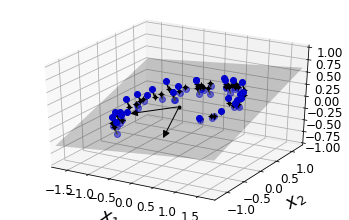

In [25]:
# plot the 3D dataset, the plane and the projections on that plane
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

plt.show()

Notice that all training instances lie close to a plane: this is a lower-dimensional (2D) subspace of the high-dimensional (3D) space. 

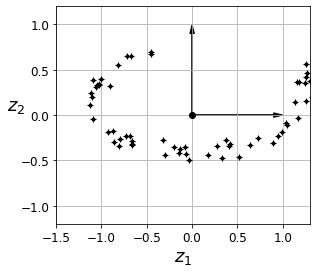

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)


Every training instance is projected perpendicularly onto this subspace (as represented by the short lines connecting the instances to the plane).

However, projection is not always the best approach to dimensionality reduction. In many cases the subspace may twist and turn, such as in the famous Swiss roll toy dataset:

In [27]:
# swiss roll dataset
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

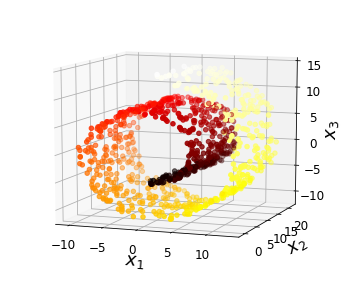

In [29]:
# plotting swiss roll
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

Simply projecting onto a plane (e.g., by dropping x3) would squash different layers of the Swiss roll together.

##### Second approach: Manifold learning

The Swiss roll is an example of a 2D manifold. Put simply, a 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space. Generally, a d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane. In the case of the Swiss roll, d = 2 and n = 3: it locally resembles a 2D plane, but it is rolled in the third dimension.

Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called Manifold Learning. It relies on the manifold assumption, also called the manifold hypothesis, which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold.

MNIST dataset: all handwritten digit images have some similarities. They are made of connected lines, the borders are white, they are more or less centered, and so on. If you randomly generated images, only a ridiculously tiny fraction of them would look like handwritten digits. In other words, the degrees of freedom available to you if you try to create a digit image are dramatically lower than the degrees of freedom you would have if you were allowed to generate any image you wanted. These constraints tend to squeeze the dataset into a lower-dimensional manifold.

The manifold assumption is often accompanied by another implicit assumption: that the task at hand (e.g., classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold.

##### 2. PCA

PCA identifies the hyperplane that lies closest to the data, and then it projects the data onto it. 

##### Preserving the variance

Before you can project the training set onto a lower-dimensional hyperplane, you first need to choose the right hyperplane. 

It seems reasonable to select the axis that preserves the maximum amount of var‐ iance, as it will most likely lose less information than the other projections. Another way to justify this choice is that it is the axis that minimizes the mean squared dis‐ tance between the original dataset and its projection onto that axis. This is the rather simple idea behind PCA.

##### Principal components

PCA identifies the axis that accounts for the largest amount of variance in the training set. It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of remaining variance. If we had a higher-dimensional dataset, PCA would also find a third axis, orthogonal to both previous axes, and a fourth, a fifth, and so on, as many axes as the number of dimensions in the dataset.

The following Python code uses NumPy’s svd() function to obtain all the principal components of the training set, then extracts the first two PCs:

In [31]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered) 
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1] # PCA assumes that the dataset is centered around the origin.

##### Projecting down to d dimensions

Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to d dimensions by projecting it onto the hyperplane defined by the first d principal components.

Selecting this hyperplane ensures that the projection will preserve as much variance as possible.

The following Python code projects the training set onto the plane defined by the first two principal components:

In [32]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [33]:
# using scikit learn
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

After fitting the PCA transformer to the dataset, you can access the principal components using the components_ variable:

In [34]:
pca.components_

array([[ 0.56791312,  0.15670748,  0.80803308],
       [-0.77712377, -0.2213858 ,  0.5891239 ]])

In [37]:
pca.components_.T[:, 0] # first principal component

array([0.56791312, 0.15670748, 0.80803308])

In [38]:
# explained variance ratio
pca.explained_variance_ratio_

array([0.40782396, 0.3020019 ])

This tells us that 41% of the dataset’s variance lies along the first axis, and 30% lies along the second axis.

##### Choosing the right number of dimensions

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is generally preferable to choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., 95%).



In [40]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# mnist dataset
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# pca
pca = PCA()
pca.fit(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [41]:
d

154

Yet another option is to plot the explained variance as a function of the number of dimensions. There will usually be an elbow in the curve, where the explained variance stops growing fast. You can think of this as the intrinsic dimensionality of the dataset.

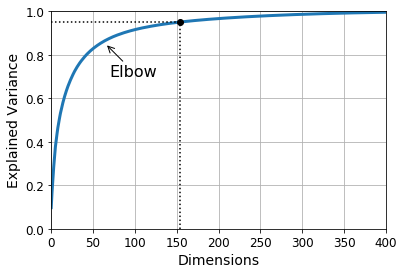

In [43]:
# explained variance plot
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

##### PCA for compression

With the MNIST dataset, while preserving 95% of its variance, we should find that each instance will have just over 150 features, instead of the original 784 features. So while most of the variance is preserved, the dataset is now less than 20% of its original size. This is a reasonable compression ratio, and we can see how this can speed up a classification algorithm (such as an SVM classifier) tremendously.

It is also possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection. Of course this won’t give us back the original data, since the projection lost a bit of information.

The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the reconstruction error.

In [46]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [47]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

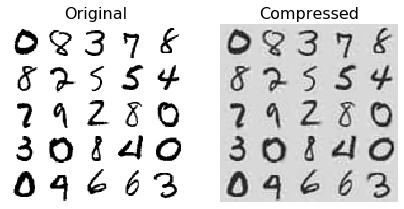

In [48]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

95% of data is preserved in the compressed version.

##### Randomized PCA

If you set the svd_solver hyperparameter to "randomized", Scikit-Learn uses a stochastic algorithm called Randomized PCA that quickly finds an approximation of the first d principal components.

In [49]:
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_reduced = rnd_pca.fit_transform(X_train)

##### Incremental PCA

One problem with the preceding implementations of PCA is that they require the whole training set to fit in memory in order for the algorithm to run. Fortunately, Incremental PCA (IPCA) algorithms have been developed: we can split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time.